In [80]:
import xgboost, textblob, string
import matplotlib.pyplot as plt 
#import data_helpers
#from DataProcessor import DataProcessor
import numpy as np
import re
import pandas as pd 
import nltk
import seaborn as sns
import string
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from nltk.stem.porter import *
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from gensim.models import word2vec
from sklearn.manifold import TSNE
from urllib.request import urlopen
from bs4 import BeautifulSoup
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
'''

Usage Example:

ridgeParams = {'C':np.linspace(.000149,.0075,50),
              'penalty':('l2',)}
lrlrd = GridSearchCV(LogisticRegression(), 
                     ridgeParams, 
                     return_train_score=True, 
                     verbose=True)
gslrd = lrlrd.fit(X,y)
GridSearchTablePlot(gslrd,"C")

'''

def GridSearchTablePlot(gridClf, paramName,
                          num_results=15,
                          negative=False,
                          graph=True,
                          displayAllParams=False,
                          largeTable=False):

    clf = gridClf.best_estimator_
    clf_params = gridClf.best_params_
    if negative:
        clf_score = -gridClf.best_score_
    else:
        clf_score = gridClf.best_score_
    clf_stdev = gridClf.cv_results_['std_test_score'][gridClf.best_index_]
    cv_results = gridClf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if displayAllParams:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + paramName]

 
    # display abreviated top 'num_results' results
    if largeTable:
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    else:
        abrevCols = ['mean_test_score','std_test_score']
        abrevCols += [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results)[abrevCols])
        

    # plot the results
    [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
    scores_df = scores_df.sort_values(by='param_' + paramName)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + paramName]

    # plot
    if graph:
        plt.figure(figsize=(8, 4))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(paramName + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(paramName)
        plt.ylabel('Score')
        plt.show()

In [3]:
'''
Usage Example:

knnModelParams = {'n_neighbors': 4,
               'weights': 'distance'}
knnModel = Model('KNN',X,y,KNeighborsClassifier(),**knnModelParams)
knnModel.performance()
'''

import time
from sklearn.model_selection import cross_val_score

class Model(object):
    
    def __init__(self,name,X,Y,modelObj,**modelParams):
        self.params = modelParams
        self.modelObj = modelObj.set_params(**self.params)  
        self.name = name
        self.X = X
        self.Y = Y
        self.initValues()   
    
    def initValues(self):
        start = time.time()
        self.modObjFit = self.modelObj.fit(self.X, self.Y)
        end = time.time()
        self.timeToFit = end - start
        self.crossVal = cross_val_score(self.modelObj, self.X, self.Y, cv=5)
        self.crossValMean = np.mean(self.crossVal)
        self.crossValRange = max(self.crossVal) - min(self.crossVal)
         
    def performance(self, boxPlot=True):
        print ("Model:\t\t" + str(self.name))
        print ("CV Mean:\t" + str(self.crossValMean))
        print ("CV Range:\t" + str(self.crossValRange))
        print ("Train Time:\t" + str(self.timeToFit))
        print ("CV Scores: ")
        print (self.crossVal)
        if boxPlot:
            fig = plt.figure()
            title = "Performance: %s" % (self.name)
            fig.suptitle(title)
            ax = fig.add_subplot(111)
            plt.boxplot(self.crossVal, showmeans=True)
            ax.set_xticklabels(self.name)
            plt.show()
    
    def compareBox(self,modelList,filterResult=0, newTitle=''):
        results = []
        names = []
        
        results.append(self.crossVal)
        names.append(self.name)
        
        for rightModel in modelList:
            if filterResult > 0:
                if rightModel.crossVal.mean() > filterResult:
                    results.append(rightModel.crossVal)
                    names.append(rightModel.name)
            else:
                results.append(rightModel.crossVal)
                names.append(rightModel.name)
        
        fig = plt.figure()
        if newTitle != '':
            title = newTitle
        else:
            title = "Performance: %s" % (self.name)
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        
        plt.boxplot(results, showmeans=True)
        ax.set_xticklabels(names)
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()
        
    def fullCompareList(self,listOfModels,folds=False):
        listOfModels.insert(0,self)
        dfout = pd.DataFrame()
        dataForFrame = []
        cvNameList= []
        for model in listOfModels:
            dataRowForFrame = {}
            dataRowForFrame = {'Name': model.name,
                                'Time':model.timeToFit,
                                'CV Mean':model.crossValMean,
                                'CV Range': model.crossValRange}
            if folds:  
                buildCvNameList = False
                if not cvNameList:
                    buildCvNameList=True
                for idx,cv in enumerate(model.crossVal):
                    cvName = 'CV Fold ' + str(idx+1)
                    if buildCvNameList:
                        cvNameList.append(cvName)
                    dataRowForFrame[cvName] = cv
            dataForFrame.append(dataRowForFrame)
        colOrder = ['Name', 'CV Mean', 'CV Range', 'Time']
        colOrder += cvNameList  
        dfOut = pd.DataFrame(dataForFrame)
        dfOut = dfOut[colOrder]
        display(dfOut)
        lgrbg = listOfModels.pop(0)
        self.compareBox(listOfModels)    

#  Detecting Irony in Twitter

 
 <br><font size=5 color='red'>WARNING: EXPLICIT LANGUAGE</font>

The information in this notebook has been taken from twitter and contains explicit language

# Introduction

Irony and sarcasm detection is an area of Natural Language Processing that both the government and social science are interested in.  The ability to detect when the opposite of written text meant is a step toward determining intent.

# Collect Data

In [4]:
train  = pd.read_csv('data/SemEval2018-T3-taskA.txt', sep='\t', header=None)
train.columns = ['id', 'label', 'orig']

In [5]:
train.head()

,id,label,orig
0,188,1,@PowerTripKFAN Adrian was raised that way and ...
1,3298,0,@vincent_h3 At 2:30am? Who's gonna favourite i...
2,3484,1,MAMA - a Korean awards show that will be held ...
3,1537,0,NO PAİN- NO GAİN ! |#Fit #Fitness #gym |#No #...
4,2671,1,Now i officially look single. Ha the


# Baseline

In [6]:
train[train['label']==1]['label'].count()/train['label'].count()

0.48868053967528013

# Text Cleaning

In [7]:
## More Cleaning
## - Noise Removal
## - Lexicon Normalization

## Word Normalization, Spell Check

In [8]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

'''
Test With:

sentences = [
    "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
    "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
    "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/."
]

for s in sentences:
    print(" ".join(text_processor.pre_process_doc(s)))
    
'''

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",
    #   'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    #tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)



Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [9]:
train['orig2norm'] = train['orig'].apply(text_processor.pre_process_doc)

In [10]:
train[0:2]

,id,label,orig,orig2norm
0,188,1,@PowerTripKFAN Adrian was raised that way and ...,<user> Adrian was raised that way and he made ...
1,3298,0,@vincent_h3 At 2:30am? Who's gonna favourite i...,<user> At <time> ? Who's gonna favourite it? A...


## Object Standardization

### Create Lookup Dictionary

Pull internet text slang from netlingo.com to create a dictionary to be used to clean text.

In [11]:
quote_page = 'https://www.netlingo.com/acronyms.php'
page = urlopen(quote_page)
soup = BeautifulSoup(page, 'html.parser')
list_box = soup.find('div', attrs={'class': 'list_box3'})
exspansions = list_box.find_all('div')
acronyms = list_box.find_all('a')

In [12]:
# create a dictionary and fill up
lookup_dict_orig = {}
for i,ac in enumerate (acronyms):
    # some acronyms are split by 'or'; the first
    # listed in the most common
    acronym = ac.text.strip().split('or', 1)[0].lower()
    # some expansion are split by '-or-' or '-or'; the first
    # listed in the most common    
    exspansion = exspansions[i].text.strip().split('-or', 1)[0].lower()
    lookup_dict_orig[acronym] = exspansion

In [13]:
# copy to new dictionary so this cell can 
# be executed multiple times
lookup_dict_updated = lookup_dict_orig.copy()

# corrections/additions
lookup_dict_updated['rt'] = 'retweet'

# exaggerations
lookup_dict_updated['aaaaaaaaand'] ='and'
lookup_dict_updated['aaaaaaand'] = 'and'
lookup_dict_updated['aaaaaamd'] = 'and'
lookup_dict_updated['aaaaaand'] ='and'
lookup_dict_updated['aaaah'] = 'and'
lookup_dict_updated['aaaaint'] = 'am not'
lookup_dict_updated['aaaawww'] = 'aw'
lookup_dict_updated['aaand'] = 'and'
lookup_dict_updated['aand'] = 'and'

# common misspellings
lookup_dict_updated['notcie'] = 'notice'

# dictionary thinks these are acronyms; these are
# more often not acronyms
del lookup_dict_updated['was']

### Replace Jargon and Acronyms

In [14]:
def _lookup_words(input_text):
    words = input_text.split() 
    new_words = [] 
    for word in words:
        if word.lower() in lookup_dict_updated:
            word = lookup_dict_updated[word.lower()]
        new_words.append(word) 
        new_text = " ".join(new_words) 
    return new_text

In [15]:
train['norm2replace'] = train['orig2norm'].apply(_lookup_words)

In [16]:
train['text'] = train['norm2replace']

## Remove Twitter Handles

In [17]:
''' 
remove unwanted text patterns from the tweets

input_txt: original string of text 
pattern: pattern of text to remove from the string

Return: same input string without the given pattern
'''
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

In [18]:
# remove twitter handles (@user)
train['text'] = np.vectorize(remove_pattern)(train['text'], "@[\w]*")

## Remove Punctuation, Numbers and Special Characters

In [19]:
''' 
remove punctuation, numbers and special characters

tweet: tweet string of text 

Return: same input string without punctuation, numbers and special characters
'''
def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

In [20]:
#train_clean = train['text'].apply(clean_tweet)

In [21]:
train['text'] = train['text'].str.replace("[^a-zA-Z#]", " ")

## Remove Short Words

In [22]:
train['text'] = train['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [23]:
train.head()

,id,label,orig,orig2norm,norm2replace,text
0,188,1,@PowerTripKFAN Adrian was raised that way and ...,<user> Adrian was raised that way and he made ...,<user> Adrian was raised that way and he made ...,user Adrian raised that made Maybe thought tha...
1,3298,0,@vincent_h3 At 2:30am? Who's gonna favourite i...,<user> At <time> ? Who's gonna favourite it? A...,<user> At <time> i have a question Who's gonna...,user time have question gonna favourite
2,3484,1,MAMA - a Korean awards show that will be held ...,MAMA - a Korean awards show that will be held ...,MAMA - a Korean awards show that will be held ...,MAMA Korean awards show that will held Hong Ko...
3,1537,0,NO PAİN- NO GAİN ! |#Fit #Fitness #gym |#No #...,NO PAİN- NO GAİN ! |Fit Fitness gym |No Give U...,not online PAİN- not online GAİN i have a comm...,online online have comment Fitness Give
4,2671,1,Now i officially look single. Ha the,Now i officially look single. Ha the,Now i officially look single. Ha the,officially look single


## Tokenize

In [24]:
tokenized_tweet = train['text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [user, Adrian, raised, that, made, Maybe, thou...
1       [user, time, have, question, gonna, favourite]
2    [MAMA, Korean, awards, show, that, will, held,...
3       [online, online, have, comment, Fitness, Give]
4                           [officially, look, single]
Name: text, dtype: object

## Stemming

In [25]:
def nat_lang(strng):
    '''Word stemmer; find the root of the word. E.g. 'dogs' becomes 'dog'''
    lmt = WordNetLemmatizer()
    strng = strng.lower()
    strng = lmt.lemmatize(strng)
    word = stemmer.stem(strng)
    return word

In [26]:
# strip suffixes
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [nat_lang(i) for i in x]) # stemming
tokenized_tweet.head()

0    [user, adrian, rais, that, made, mayb, thought...
1        [user, time, have, question, gonna, favourit]
2    [mama, korean, award, show, that, will, held, ...
3             [onlin, onlin, have, comment, fit, give]
4                                [offici, look, singl]
Name: text, dtype: object

In [27]:
# un-tokenize
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

    train['text'] = tokenized_tweet

# Analyze Data Set

In [28]:
## Word Counts
## Word Clouds
## Clustering
## Unsupervised Topic

## Most Common Words in Tweets

In [29]:
def sentences_to_words(sentence_list, drop_words=None):
    
    words = ' '.join([text for text in sentence_list])
    if drop_words:
        for wrd in drop_words:
            # replace only the exact word
            words = re.sub(r"\b%s\b" % wrd , 
               r"%s" % '', 
               words, 
               flags=re.IGNORECASE)
            # get rid of double spaces left from sub
            words = words.replace('  ',' ')
    return words

In [30]:
def sentences_to_wordcloud(sentence_list, drop_words_list=None):
    
    words = sentences_to_words(sentence_list, drop_words_list)
    
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=21, 
                          collocations=False,
                          max_font_size=110).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()  

In [31]:
from operator import itemgetter

def sentences_to_sortedwordcount(sentence_list, drop_words_list=None):
    
    words = sentences_to_words(sentence_list, drop_words_list)
    counts = {}
    words = words.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    
    sortedwords = sorted(counts.items(), key=itemgetter(1), reverse = True)
     
    return sortedwords

In [32]:
def wordcount_to_bar(x_label, y_label, word_count_tuple):
    a = dict(word_count_tuple)
    d = pd.DataFrame({x_label: list(a.keys()),
                      y_label: list(a.values())})
    # selecting top 10 most frequent hashtags     
    d = d.nlargest(columns=y_label, n = 10) 
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d, x=x_label, y=y_label)
    ax.set(ylabel=y_label)
    plt.show()


In [33]:
drop_words = ['user','number'] + stopwords.words('english')

### Word Cloud and Word Counts: All Tweets

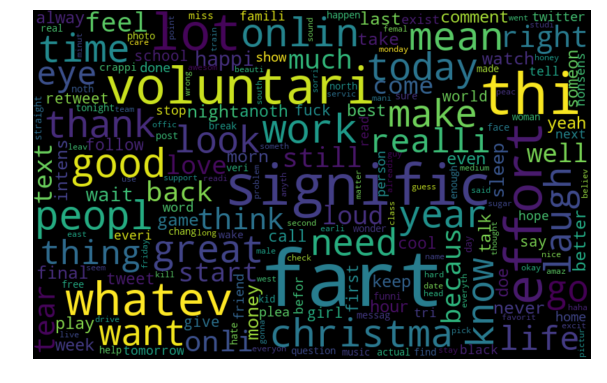

In [34]:
sentences_to_wordcloud(train['text'], drop_words)

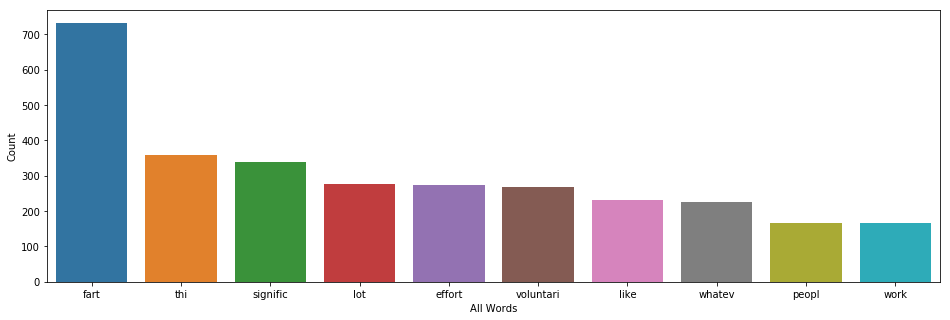

In [35]:
wordcount_all = sentences_to_sortedwordcount(train['text'], drop_words)
wordcount_to_bar('All Words', 'Count', wordcount_all)

### Word Cloud and Word Counts: Non-Ironic Tweets

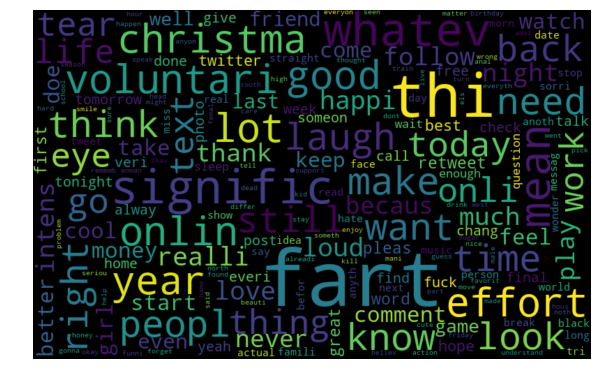

In [36]:
sentences_to_wordcloud(train['text'][train['label']==0], drop_words)

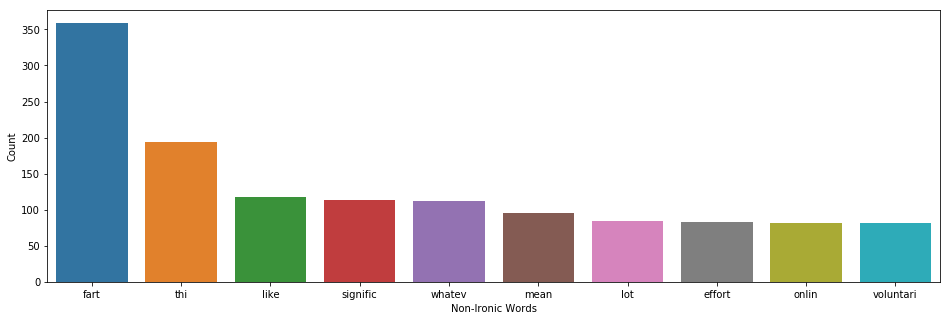

In [37]:
wordcount_nonironic = sentences_to_sortedwordcount(train['text'][train['label']==0], drop_words)
wordcount_to_bar('Non-Ironic Words', 'Count', wordcount_nonironic)

### Word Cloud and Word Counts: Ironic Tweets

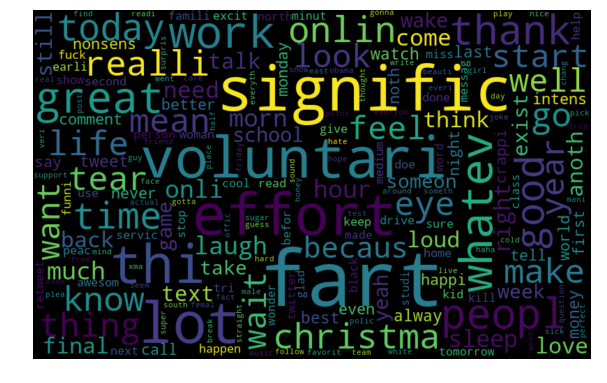

In [38]:
sentences_to_wordcloud(train['text'][train['label']==1], drop_words)

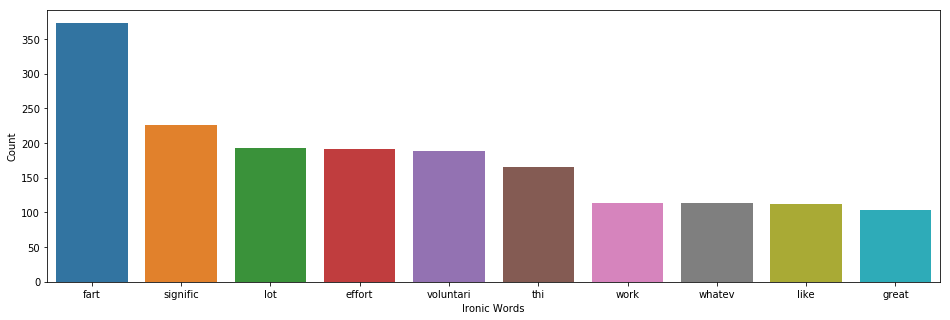

In [39]:
wordcount_ironic = sentences_to_sortedwordcount(train['text'][train['label']==1], drop_words)
wordcount_to_bar('Ironic Words', 'Count', wordcount_ironic)

## Unique Words

### Unique Word Cloud and Word Counts: Non-Ironic Tweets

In [40]:
ironic_words = sentences_to_words(train['text'][train['label']==1]).split()
nonironic_words = sentences_to_words(train['text'][train['label']==0]).split()

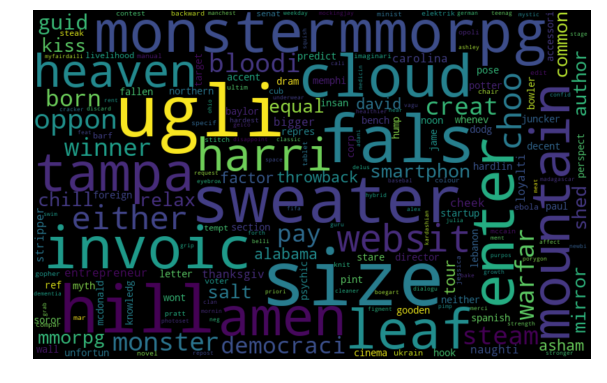

In [41]:
sentences_to_wordcloud(train['text'][train['label']==0], drop_words+ironic_words) 


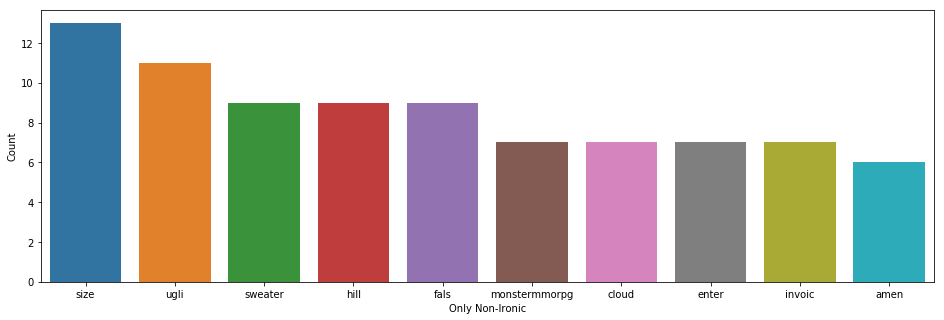

In [42]:
wordcount_only_nonironic = sentences_to_sortedwordcount(train['text'][train['label']==0], drop_words+ironic_words) 
wordcount_to_bar('Only Non-Ironic', 'Count', wordcount_only_nonironic)

### Unique Word Cloud and Word Counts: Ironic Tweets


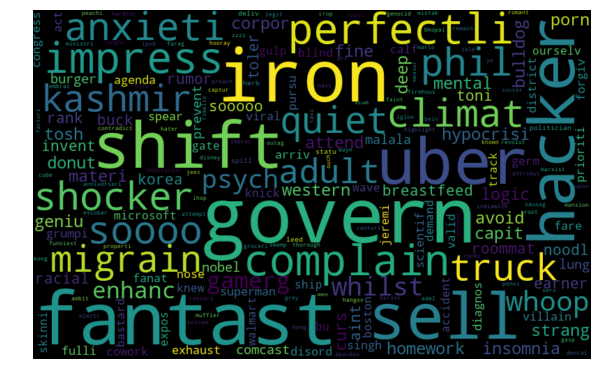

In [43]:
sentences_to_wordcloud(train['text'][train['label']==1], drop_words+nonironic_words) 


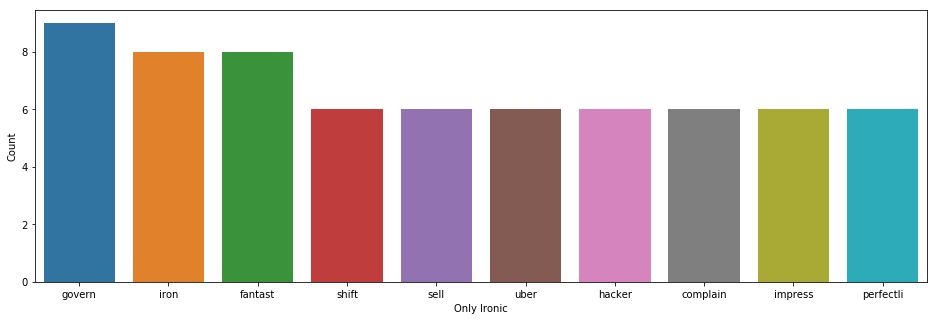

In [44]:
wordcount_only_ironic=sentences_to_sortedwordcount(train['text'][train['label']==1], drop_words+nonironic_words)[:10] 
wordcount_to_bar('Only Ironic', 'Count', wordcount_only_ironic)

## Hashtags and Irony

In [45]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        ht = ' '.join(ht)
        if ht != '':
            hashtags.append(ht)

    return hashtags

In [49]:
def sentences_to_sorted_hashtags(sentence_list, drop_words=None):
    ht_only = hashtag_extract(sentence_list)
    return sentences_to_sortedwordcount(ht_only, drop_words)

### Non-Ironic Hashtags

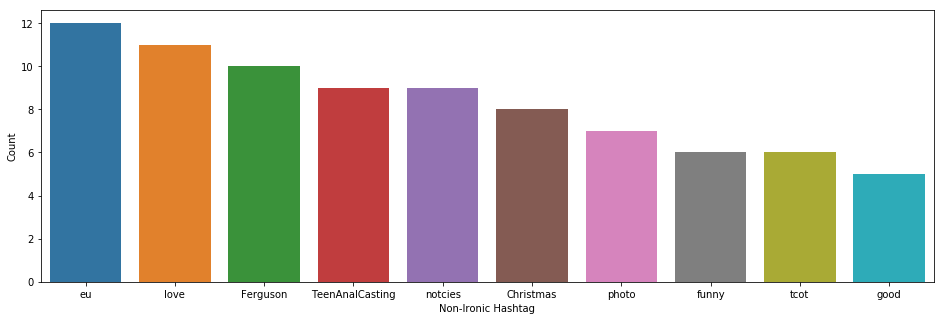

In [50]:
nonironic_hashtags = sentences_to_sorted_hashtags(train['orig'][train['label']==0], drop_words)
wordcount_to_bar('Non-Ironic Hashtag','Count',nonironic_hashtags)

### Ironic Hashtages

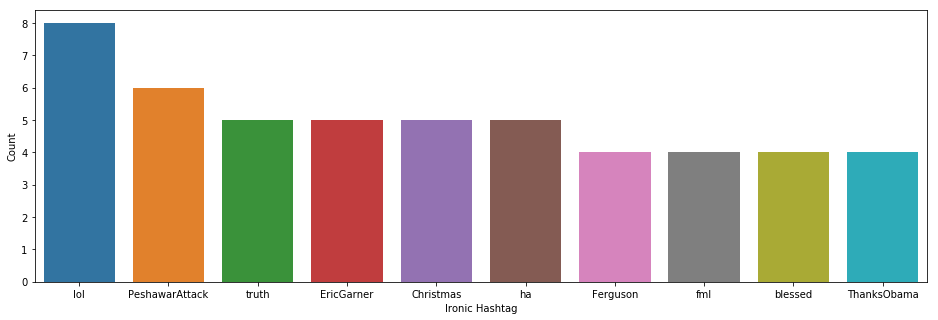

In [51]:
ironic_hashtags = sentences_to_sorted_hashtags(train['orig'][train['label']==1], drop_words)
wordcount_to_bar('Ironic Hashtag','Count',ironic_hashtags)

## Visualizing Word Vectors

In [52]:
def build_corpus(data):
    "Creates a list of lists containing words from each tweet"
    corpus = []
    for sentence in data['text'].iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)       
    return corpus

In [53]:
corpus = build_corpus(train)

In [54]:
corpus = build_corpus(train)        
corpus[0:2]

[['user',
  'adrian',
  'rais',
  'that',
  'made',
  'mayb',
  'thought',
  'that',
  'would',
  'motiv',
  'there'],
 ['user', 'time', 'have', 'question', 'gonna', 'favourit']]

In [55]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [56]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=50, workers=4)

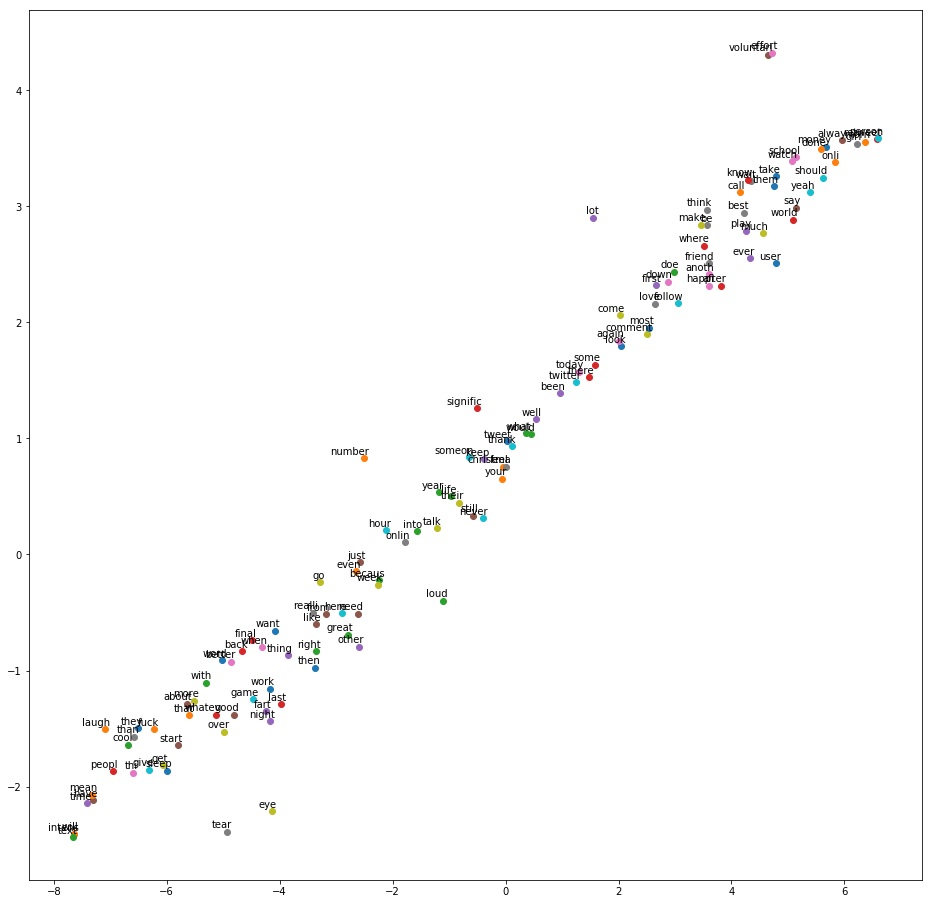

In [57]:
tsne_plot(model)

## Topic Modelling

In [58]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [59]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [60]:
vect=CountVectorizer(ngram_range=(1,1),stop_words='english')

In [61]:
dtm=vect.fit_transform(train['text'])

In [62]:
dtm

<4373x6614 sparse matrix of type '<class 'numpy.int64'>'
	with 31992 stored elements in Compressed Sparse Row format>

In [63]:
pd.DataFrame(dtm.toarray(),columns=vect.get_feature_names())

,aaaaaaand,aaaah,aaron,abandon,abba,abbrevi,abbv,abdullah,abey,abil,...,zionist,zipper,zoella,zoloft,zombi,zone,zuckerberg,zuma,zzzz,zzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
lda=LatentDirichletAllocation(n_components=4)

In [65]:
lda.fit_transform(dtm)

array([[0.03573133, 0.40780154, 0.52071989, 0.03574724],
       [0.34101391, 0.27907905, 0.04214673, 0.33776031],
       [0.02500528, 0.02500401, 0.02500611, 0.9249846 ],
       ...,
       [0.37026849, 0.03591378, 0.55809845, 0.03571929],
       [0.15137267, 0.18239862, 0.16394653, 0.50228218],
       [0.47731139, 0.03681805, 0.44998951, 0.03588106]])

In [66]:
lda_dtf=lda.fit_transform(dtm)

In [67]:
import numpy as np
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names())

In [68]:
import mglearn
mglearn.tools.print_topics(topics=range(4), feature_names=features,
sorting=sorting, topics_per_chunk=4, n_words=10)

topic 0       topic 1       topic 2       topic 3       
--------      --------      --------      --------      
fart          lot           user          number        
eye           effort        number        thi           
tear          voluntari     fart          fart          
signific      laugh         good          mean          
peopl         loud          great         just          
alway         thi           thank         signific      
make          just          signific      christma      
tweet         better        onlin         know          
stop          comment       just          like          
girl          best          whatev        today         




In [69]:
from __future__ import  print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [70]:
zit=pyLDAvis.sklearn.prepare(lda,dtm,vect)

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [71]:
pyLDAvis.display(zit)

# Prepare for Feature Creation

In [72]:
# split the dataset into training and validation datasets 
x_train, x_test, y_train, y_test = model_selection.train_test_split(train['text'], train['label'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

# Count Vector Features

In [73]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
X = count_vect.fit(x_train)

In [74]:
# transform the training and data using count vectorizer object
xtrain_count =  count_vect.transform(x_train)
xtest_count =  count_vect.transform(x_test)

# TF-IDF Vector Features

## word level tf-idf

In [75]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(x_train)
xtrain_tfidf =  tfidf_vect.transform(x_train)
xtest_tfidf =  tfidf_vect.transform(x_test)

## ngram level tf-idf 

In [76]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(x_train)
xtrain_tfidf_ngram = tfidf_vect_ngram.transform(x_train)
xtest_tfidf_ngram = tfidf_vect_ngram.transform(x_test)

## character level tf-idf

In [77]:
# character level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(x_train)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train)
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test)


# Word Embedding Features

In [78]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('data/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')


In [82]:
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(x_train)
word_index = token.word_index

In [83]:
# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(x_train), maxlen=70)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(x_test), maxlen=70)


In [84]:
# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Models

In [85]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

## Naive Bayes

In [86]:
nb_count_vectors = Model('NB Count Vectors',xtrain_count,y_train,naive_bayes.MultinomialNB())
nb_tfidf_word = Model('NB Word TF-IDF',xtrain_tfidf,y_train,naive_bayes.MultinomialNB())
nb_tfidf_ngram = Model('NB N-Gram',xtrain_tfidf_ngram,y_train,naive_bayes.MultinomialNB())
nb_ftidf_ngram_chars = Model('NB Char TF-IDF',xtrain_tfidf_ngram_chars,y_train,naive_bayes.MultinomialNB())

,Name,CV Mean,CV Range,Time
0,NB Count Vectors,0.624579,0.019847,0.054563
1,NB Word TF-IDF,0.615730,0.051908,0.003875
2,NB N-Gram,0.602017,0.033486,0.003634
3,NB Char TF-IDF,0.603221,0.043873,0.026823


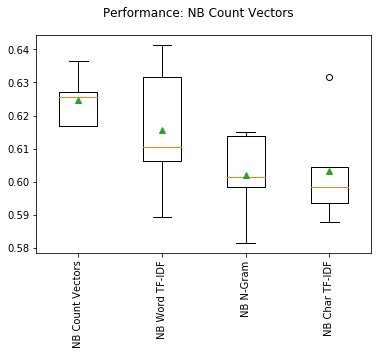

In [87]:
nb_count_vectors.fullCompareList([nb_tfidf_word,nb_tfidf_ngram,nb_ftidf_ngram_chars])

## Linear Classifier

In [88]:
lc_count_vectors = Model('LC Count Vectors',xtrain_count,y_train,linear_model.LogisticRegression())
lc_tfidf_word = Model('LC Word TF-IDF',xtrain_tfidf,y_train,linear_model.LogisticRegression())
lc_tfidf_ngram = Model('LC N-Gram',xtrain_tfidf_ngram,y_train,linear_model.LogisticRegression())
lc_ftidf_ngram_chars = Model('LC Char TF-IDF',xtrain_tfidf_ngram_chars,y_train,linear_model.LogisticRegression())

,Name,CV Mean,CV Range,Time
0,LC Count Vectors,0.619695,0.056317,0.062993
1,LC Word TF-IDF,0.628537,0.037715,0.009789
2,LC N-Gram,0.602616,0.019492,0.010555
3,LC Char TF-IDF,0.605356,0.034731,0.054261


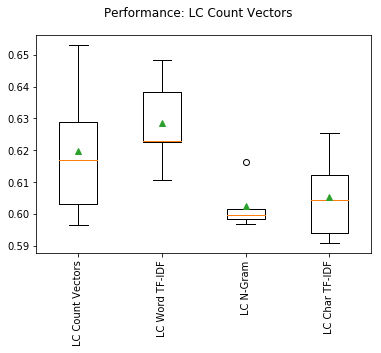

In [89]:
lc_count_vectors.fullCompareList([lc_tfidf_word,lc_tfidf_ngram,lc_ftidf_ngram_chars])

## SVM

In [96]:
svm_count_vectors = Model('SVM Count Vectors',xtrain_count,y_train,svm.SVC())
svm_tfidf_ngram = Model('SVM N-Gram',xtrain_tfidf_ngram,y_train,svm.SVC())

,Name,CV Mean,CV Range,Time
0,SVM Count Vectors,0.508387,0.000026,1.105171
1,SVM N-Gram,0.508387,0.000026,0.420118


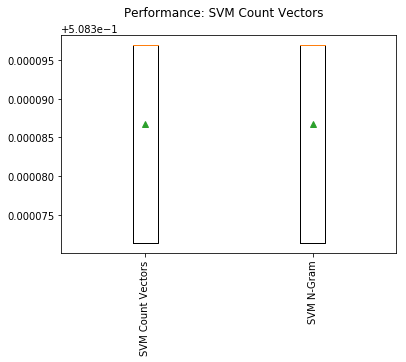

In [98]:
svm_count_vectors.fullCompareList([svm_tfidf_ngram])

## Extreme Gradient Boosting

In [92]:
xgb_count_vectors = Model('XGB Count Vectors',xtrain_count,y_train,xgboost.XGBClassifier())
xgb_tfidf_word = Model('XGB Word TF-IDF',xtrain_tfidf,y_train,xgboost.XGBClassifier())
xgb_ftidf_ngram_chars = Model('XGB Char TF-IDF',xtrain_tfidf_ngram_chars,y_train,xgboost.XGBClassifier())

,Name,CV Mean,CV Range,Time
0,SVM Count Vectors,0.508387,0.000026,1.233062
1,XGB Word TF-IDF,0.609936,0.030534,0.653803
2,XGB Char TF-IDF,0.599578,0.035363,5.769050


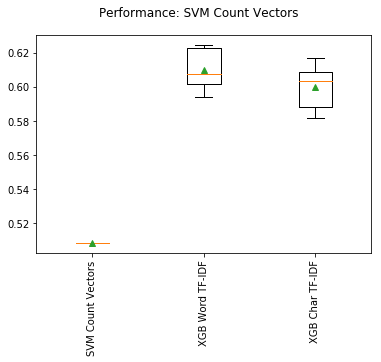

In [93]:
svm_count_vectors.fullCompareList([xgb_tfidf_word, xgb_ftidf_ngram_chars])